In [51]:


import os
import argparse
import sys
import time
from math import ceil
import matplotlib.pyplot as plt
import MNN
import cv2
import numpy as np
import torch

import box_utils_numpy as box_utils



image_mean = np.array([127, 127, 127])
image_std = 128.0
iou_threshold = 0.3
center_variance = 0.1
size_variance = 0.2
min_boxes = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
strides = [8, 16, 32, 64]
model_path = "../model/version-slim/slim-320-quant-ADMM-50.mnn"




priors nums:4420
Inference Time 0.036889076232910156


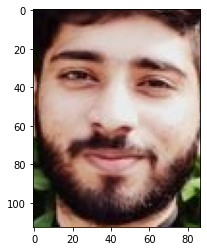

priors nums:4420
Inference Time 0.0522770881652832


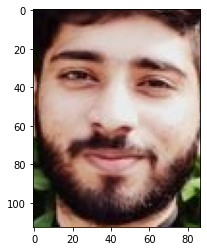

priors nums:4420
Inference Time 0.04684901237487793


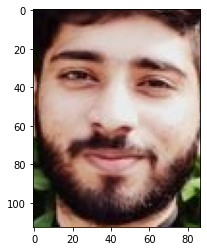

priors nums:4420
Inference Time 0.06598472595214844


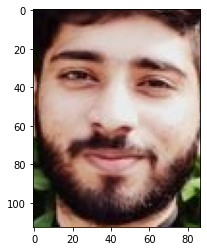

priors nums:4420
Inference Time 0.0586237907409668


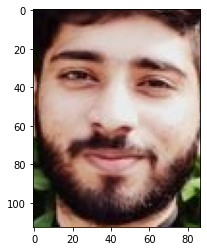

priors nums:4420
Inference Time 0.062103986740112305


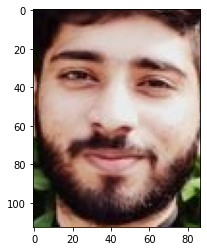

priors nums:4420
Inference Time 0.043184757232666016


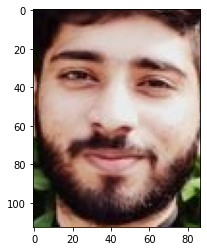

priors nums:4420
Inference Time 0.04942488670349121


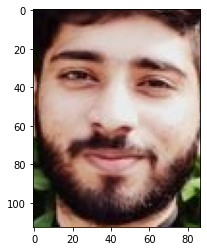

priors nums:4420
Inference Time 0.04339718818664551


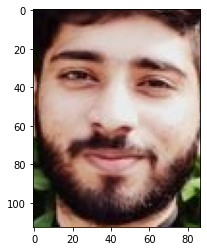

In [53]:
def define_img_size(image_size):
    shrinkage_list = []
    feature_map_w_h_list = []
    for size in image_size:
        feature_map = [ceil(size / stride) for stride in strides]
        feature_map_w_h_list.append(feature_map)

    for i in range(0, len(image_size)):
        shrinkage_list.append(strides)
    priors = generate_priors(feature_map_w_h_list, shrinkage_list, image_size, min_boxes)
    return priors


def generate_priors(feature_map_list, shrinkage_list, image_size, min_boxes, clamp=True):
    priors = []
    for index in range(0, len(feature_map_list[0])):
        scale_w = image_size[0] / shrinkage_list[0][index]
        scale_h = image_size[1] / shrinkage_list[1][index]
        for j in range(0, feature_map_list[1][index]):
            for i in range(0, feature_map_list[0][index]):
                x_center = (i + 0.5) / scale_w
                y_center = (j + 0.5) / scale_h

                for min_box in min_boxes[index]:
                    w = min_box / image_size[0]
                    h = min_box / image_size[1]
                    priors.append([
                        x_center,
                        y_center,
                        w,
                        h
                    ])
    print("priors nums:{}".format(len(priors)))
    priors = torch.tensor(priors)
    if clamp:
        torch.clamp(priors, 0.0, 1.0, out=priors)
    return priors


def predict(width, height, confidences, boxes, prob_threshold, iou_threshold=0.3, top_k=-1):
    boxes = boxes[0]
    confidences = confidences[0]
    picked_box_probs = []
    picked_labels = []
    for class_index in range(1, confidences.shape[1]):
        probs = confidences[:, class_index]
        mask = probs > prob_threshold
        probs = probs[mask]
        if probs.shape[0] == 0:
            continue
        subset_boxes = boxes[mask, :]
        box_probs = np.concatenate([subset_boxes, probs.reshape(-1, 1)], axis=1)
        box_probs = box_utils.hard_nms(box_probs,
                                       iou_threshold=iou_threshold,
                                       top_k=top_k,
                                       )
        picked_box_probs.append(box_probs)
        picked_labels.extend([class_index] * box_probs.shape[0])
    if not picked_box_probs:
        return np.array([]), np.array([]), np.array([])
    picked_box_probs = np.concatenate(picked_box_probs)
    picked_box_probs[:, 0] *= width
    picked_box_probs[:, 1] *= height
    picked_box_probs[:, 2] *= width
    picked_box_probs[:, 3] *= height
    return picked_box_probs[:, :4].astype(np.int32), np.array(picked_labels), picked_box_probs[:, 4]


def inference(image_ori: np.asarray) -> np.asarray:
    """Crop face from Image
    1. If their are no face in image it will return 0
    2. If their are more than 1 face it will return 0
    
    Args:
        image_ori = Full image with face
    
    Output:
        np.asarray: Cropped face image numpy array
    
    """
    # Variables
    input_size = (320,240)
    threshold = 0.7
    # Loading model
    interpreter = MNN.Interpreter(model_path)
    priors = define_img_size(input_size)
    session = interpreter.createSession()
    input_tensor = interpreter.getSessionInput(session)
    # Preprocessing Image
    image = cv2.cvtColor(image_ori, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, tuple(input_size))
    image = (image - image_mean) / image_std
    image = image.transpose((2, 0, 1))
    image = image.astype(np.float32)
    tmp_input = MNN.Tensor((1, 3, input_size[1], input_size[0]), MNN.Halide_Type_Float, image, MNN.Tensor_DimensionType_Caffe)
    input_tensor.copyFrom(tmp_input)
    # Running Prediction
    interpreter.runSession(session)
    scores = interpreter.getSessionOutput(session, "scores").getData()
    boxes = interpreter.getSessionOutput(session, "boxes").getData()
    boxes = np.expand_dims(np.reshape(boxes, (-1, 4)), axis=0)
    scores = np.expand_dims(np.reshape(scores, (-1, 2)), axis=0)
    boxes = box_utils.convert_locations_to_boxes(boxes, priors, center_variance, size_variance)
    boxes = box_utils.center_form_to_corner_form(boxes)
    boxes, labels, probs = predict(image_ori.shape[1], image_ori.shape[0], scores, boxes, threshold)
    # cropping face
    if len(boxes) == 1:
        y1, x1, y2, x2 = boxes[0]
        cropped_face = image_ori[x1: x2, y1: y2]
        cropped_face = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)
        return cropped_face
    else:
        print("More than 1 faces in picture Or no Face In Image")

if __name__ == "__main__":
    
    for i in range(1, 10):
        st = time.time()
        img_path = "/Users/sohaibanwar/Documents/personals/profile_pic.jpeg"
        image_ori = cv2.imread(img_path)
        face = inference(image_ori)
        print(f"Inference Time {time.time() - st}")
        plt.imshow(face)
        plt.show()